# Capstone 1: Exploratory Data Analysis

<a id='TOC'></a>
**Table of Contents**
1. Preliminaries
    1. [Import EMS Incident Data](#Sec01A)
    2. [Import Shapefile](#Sec01B)
    3. [Incident Outcomes](#Sec01C)
2. Fatalities by Time Period
    1. [Fatality Time Series](#Sec02A)
    2. [Fatality Time Series by Year](#Sec02B)
    3. [Fatalities by Month](#Sec02C)
    4. [Fatalities by Weekday](#Sec02D)
    5. [Fatalities by Time of Day](#Sec02E)
3. Fatalities by Geographic Region
    1. [Fatalities by Borough](#Sec03A)
    2. [Fatalities by ZIP Code](#Sec03B) 
4. Incident Response Times
    1. [Total Response Times](#Sec04A)
    2. [Response Times by Incident Outcome](#Sec04B)
    3. [Response Time by Final Severity Level](#Sec04C)
5. Incident Call Types & Severity Levels
    1. [Fatalities by Call Type](#Sec05A)
    2. [Incident Outcomes by Severity Level](#Sec05B)

The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.

Exploratory data analysis was conducted prior to the development of any ML algorithms. The purpose of this process was to reveal trends that can help identify key feature variables and also provide contextual insights about the dataset.

***

## 1. PRELIMINARIES

<a id='Sec01A'></a>
#### 1A: Import EMS incident data

In [2]:
# Import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import calendar
import matplotlib.dates as mdates
from collections import OrderedDict
import seaborn as sns

import shapefile as shp
%matplotlib inline

sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [3]:
# Assign file path
file_path = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(file_path,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 28 columns):
year                           int64
month                          int64
hour                           int64
weekday                        object
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    float64
response_time                  f

In [5]:
# Change dtypes
df['weekday'] = df.weekday.astype('category')
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')
df['held_indicator'] = df.held_indicator.astype('category')
df['incident_dispatch_area'] = df.incident_dispatch_area.astype('category')
df['incident_disposition_code'] = df.incident_disposition_code.astype('category')

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 28 columns):
year                           int64
month                          int64
hour                           int64
weekday                        category
borough                        category
zipcode                        category
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 category
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         category
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    float64
response_time          

[TOC](#TOC)

<a id='Sec01B'></a>
#### 1B: Import shapefile for NYC

In [7]:
# Read shapefile data into object
shp_path = '../data/ZIP_CODE_040114/ZIP_CODE_040114.shp'
sf = shp.Reader(shp_path)

In [8]:
# Define function to read shapefile object into Pandas DataFrame
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [9]:
# Read shapefile into DataFrame
map_df = read_shapefile(sf)

In [10]:
map_df.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,coords
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"[(1038098.2518714815, 188138.38000671566), (10..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(1001613.7129640579, 186926.4395172149), (100..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(1011174.275535807, 183696.33770971), (101137..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(995908.3654508889, 183617.61280155182), (996..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(991997.1134308875, 176307.4958601296), (9920..."


This shapefile is provided by the Department of Information Technology & Telecommunications (DoITT) of the City of New York, and was last updated on September 10, 2018. [TOC](#TOC)

*[Source](https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u): NYC OpenData, ZIP Code Boundaries*

<a id='Sec01C'></a>
#### 1C: Incident Outcomes

A natural starting point to investigate this dataset was to answer the following question: How many total recorded incidents resulted in a fatality?

In [11]:
# Total Number of Fatalities Resulting from EMS Incidents (2013-2018)
df.fatality.value_counts()

False    7649344
True      338684
Name: fatality, dtype: int64

In [12]:
# Subset all incidents based on outcome
fatalities = df[df.fatality==True]
survivals = df[df.fatality==False]

In [13]:
# Total Percentage of Fatalities Resulting from EMS Incidents (2013-2018)
df.fatality.value_counts(normalize=True)

False    0.957601
True     0.042399
Name: fatality, dtype: float64

Of the 7,988,028 observations used in this analysis, only 338,684 (~4.24%) resulted in a fatality. [TOC](#TOC)

*** 

## 2. FATALITIES BY TIME PERIOD

<a id='Sec02A'></a>
##### 2A: Fatality Time Series (1/2013 - 12/2018)

How does the frequency of fatalities vary throughout the six-year reporting period?

In [14]:
# Group frequency of fatalities by month spanning 1/2013 - 12/2018
death_plot = fatalities[['fatality']].groupby(fatalities.index.to_period("M")).sum()

In [15]:
death_plot.sort_values('fatality',ascending=False)

,fatality
incident_datetime,
2018-06,6360.0
2018-07,6185.0
2018-05,6006.0
2018-08,5973.0
2017-06,5691.0
...,...
2013-11,3748.0
2013-04,3646.0
2013-03,3430.0


In [16]:
# Define function to annotate maximum value on plot
def lbl_max_value(dfObj,ax,lbl_txt=None,x_off=0,y_off=0):
    """
    This function labels the maximum 
    value of a series on an axis plot
    
    Parameter(s)
    ------------
    dfObj:   Pandas DataFrame object
    ax:      an Axis object
    lbl_txt: principal label text (default=None)
    x_off:   offset value for x-position of label text (default=0)
    y_off:   offset value for y-position of label text (default=0)
        
    Returns
    -------
    NoneType (renders an annotation on plot)
    """
    if lbl_txt == None:
        lbl_txt = dfObj.fatality.idxmin()
    else:
        str(lbl_txt)+'\n'
    ax.annotate('{0}\nDeaths: {1}'.format(lbl_txt,str(int(dfObj.fatality.max()))),
              xy=(str(dfObj.fatality.idxmax()),dfObj.fatality.max()),
              xytext=(str(dfObj.fatality.idxmax()+x_off),dfObj.fatality.max()+y_off),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

# Define function to annotate minimum value on plot
def lbl_min_value(dfObj,ax,lbl_txt=None,x_off=0,y_off=0):
    """
    This function labels the minimum 
    value of a series on an axis plot
    
    Parameter(s)
    ------------
    dfObj:   Pandas DataFrame object
    ax:      an Axis object
    lbl_txt: principal label text (default=None)
    x_off:   offset value for x-position of label text (default=0)
    y_off:   offset value for y-position of label text (default=0)
        
    Returns
    -------
    NoneType (renders an annotation on plot)
    """
    if lbl_txt == None:
        lbl_txt = dfObj.fatality.idxmin()
    else:
        str(lbl_txt)+'\n'
    ax.annotate('{0}\nDeaths: {1}'.format(lbl_txt,str(int(dfObj.fatality.min()))),
              xy=(str(dfObj.fatality.idxmin()),dfObj.fatality.min()),
              xytext=(str(dfObj.fatality.idxmin()+x_off),dfObj.fatality.min()+y_off),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


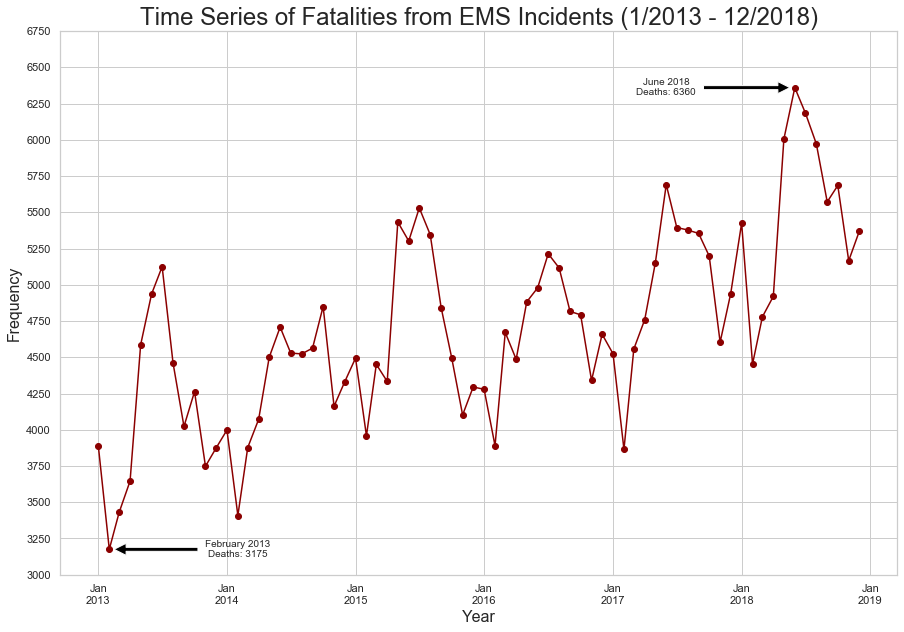

In [17]:
# Format xticks and axes
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%b\n%Y')

# Create plot, title, and axes labels
fig1A, ax1A = plt.subplots(figsize=(15,10))
ax1A.plot(death_plot.index.astype('datetime64'),
          death_plot.fatality,
          color='#8b0000',marker='o')

ax1A.set_title('Time Series of Fatalities from EMS Incidents (1/2013 - 12/2018)',size=24)
ax1A.set_xlabel('Year',size=16)
ax1A.set_ylabel('Frequency',size=16)
ax1A.set_yticks([3000 + 250*i for i in range(16)])

ax1A.xaxis.set_major_locator(years)
ax1A.xaxis.set_major_formatter(years_fmt)

# Label months with maximum and minimum fatality
#lbl_metric_value(death_plot,ax1A,np.max,lbl_txt='June 2018',x_off=-12,y_off=0)

lbl_max_value(death_plot,ax1A,lbl_txt='June 2018',x_off=-12,y_off=0)
lbl_min_value(death_plot,ax1A,lbl_txt='February 2013',x_off=+12,y_off=0)

#plt.savefig('../graphics/CP1-02_fig02A.png') # Export plot to PNG file
plt.show()

The time series above illustrates an upward trend in the monthly number of fatalities that result from EMS incidents across the six-year observation period (2013 through 2018). In addition, the frequency of fatalities tend to spike during the middle of each year. This observation warrants a closer inspection to determine whether or not the incident month is a deterministic factor of a fatality. [TOC](#TOC)

<a id='Sec02B'></a>
#### 2B: Fatality Time Series by Year

Are there noticeable trends in fatalities per year?

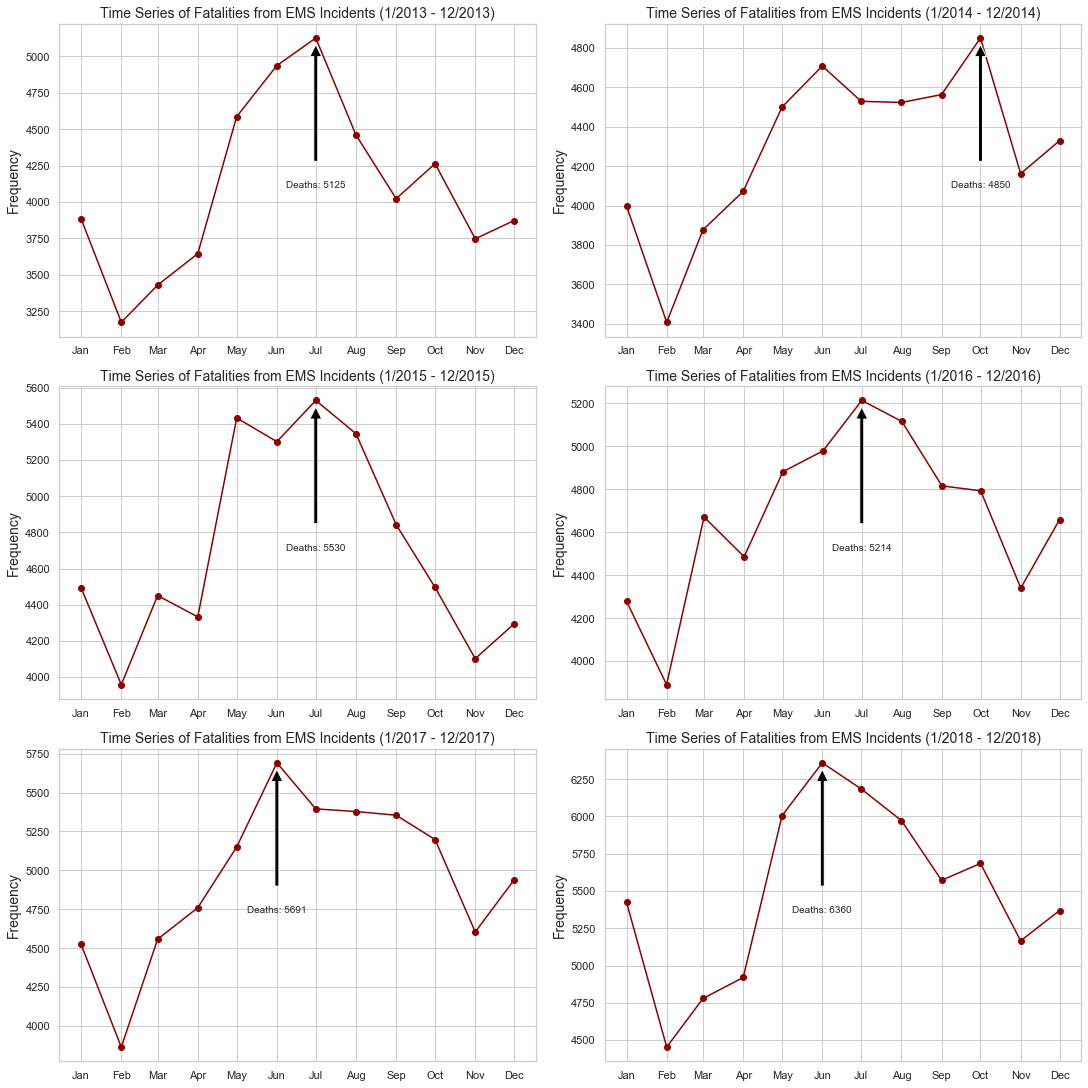

In [18]:
# Create list of years spanned by dataset
years = list(fatalities.index.year.unique())

# Create tuples for start and end month of each year
death_period = [(str(year)+'-01',str(year)+'-12') for year in years]

# Create 'death_plot' subsets for each year
dplot_arr = [death_plot.loc[str(s):str(e),:] for s,e in death_period]
    
# Initialize plot and axes
nrows = int(math.ceil(len(dplot_arr)/2)) # half the length of 'dplot_arr'
ncols = 2
fig1B, ax1B = plt.subplots(nrows,ncols,figsize=(15,15),constrained_layout=True)

# Plot each 'death_plot' subset on its own axis
for k, ax in enumerate(ax1B.flat):
    ax.plot(np.array(dplot_arr[k].index.astype('datetime64')),
            np.array(dplot_arr[k].fatality),
            color='#8b0000',
            marker='o')
    ax.set_title('Time Series of Fatalities from EMS Incidents (1/{0} - 12/{0})'
                 .format(dplot_arr[k].index[0].year),size=14)
    ax.set_ylabel('Frequency',size=14)
    
    # Format xticks
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    
    # Label maximum value
    y_off = (float(dplot_arr[k].fatality.max()-dplot_arr[k].fatality.min())/2)
    lbl_max_value(dplot_arr[k],ax,lbl_txt='',y_off=-y_off)

#plt.savefig('../graphics/CP1-02_fig02B.png') # Export plot to PNG file
plt.show()

With the exception of 2014, fatalities resulting from EMS incidents tend to peak during the summertime in either June or July. [TOC](#TOC)

<a id='Sec02C'></a>
#### 2C: Fatalities by Month

In which month of the year does the highest frequency of fatalities occur?

In [19]:
# Subset all fatalities by month
death_by_month = fatalities[['fatality']].groupby(fatalities.index.month).sum()
#death_by_month

In [20]:
# Format index
death_by_month.index = [calendar.month_abbr[i] for i in list(death_by_month.index)]

In [21]:
death_by_month

,fatality
Jan,26605.0
Feb,22748.0
Mar,25765.0
Apr,26217.0
May,30557.0
Jun,31976.0
Jul,31978.0
Aug,30796.0
Sep,29171.0
Oct,29285.0


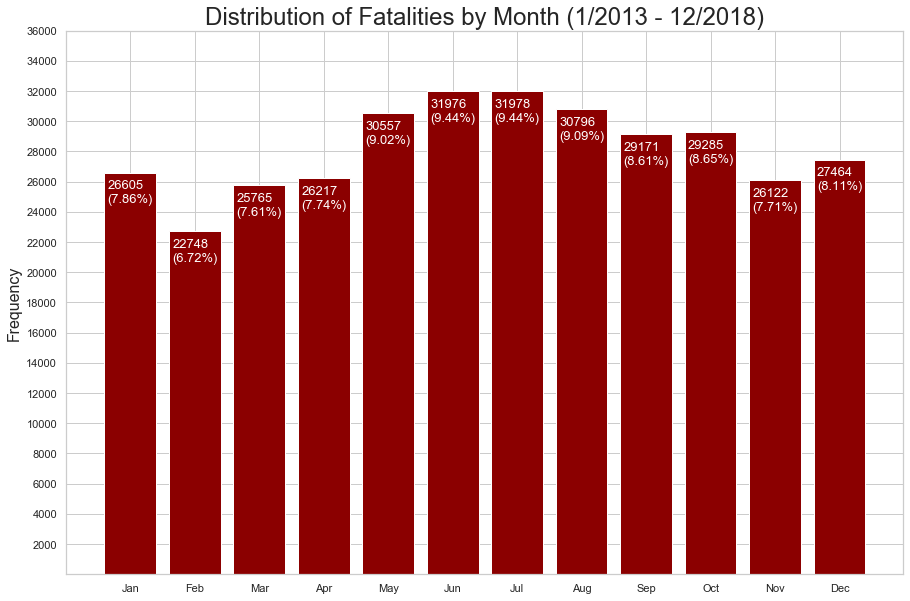

In [22]:
# Create plot, title, and axes labels
fig1C, ax1C = plt.subplots(figsize=(15,10))
ax1C.bar(death_by_month.index,
         death_by_month.fatality,
         color='#8b0000')

ax1C.set_title('Distribution of Fatalities by Month (1/2013 - 12/2018)',size=24)
ax1C.set_xticklabels(death_by_month.index)
ax1C.set_ylabel('Frequency',size=16)
ax1C.set_yticks([2000*i for i in range(1,19)])

# Create data labels
total = sum([i.get_height() for i in ax1C.patches])    
for i in ax1C.patches:
    ax1C.text(i.get_x()+0.05,
              i.get_height()-2000,
              str(int(i.get_height()))+'\n('+str(round(i.get_height()/total*100,2))+'%)',
              fontsize=13,color='white')

#plt.savefig('../graphics/CP1-02_fig02C.png') # Export plot to PNG file
plt.show()

The plot above shows that the highest monthly frequency of fatalites during the six-year observation period (2013 through 2018) generally occur in the months of June and July. However, this observation in and of itself does not necessarily suggest that the month in which an EMS incident takes place may have strong a impact on whether or not a fatality will occur given that the frequencies are similiarly high in May and August. [TOC](#TOC)

<a id='Sec02D'></a>
#### 2D: Fatalities by Weekday (2013 - 2018)

On which day of the week does the highest frequency of fatalities occur?

In [23]:
# Subset all fatalities by weekday
death_by_weekday = fatalities[['fatality']].groupby(fatalities.index.strftime('%w')).sum()

In [24]:
#death_by_weekday

In [25]:
# Format index
wk_dy = {x.strftime('%w'):x.strftime('%A') for x in fatalities.index}
od = OrderedDict(sorted(wk_dy.items(),key=lambda t: t[0]))
death_by_weekday.index = list(od.values())

In [26]:
death_by_weekday

,fatality
Sunday,45634.0
Monday,48297.0
Tuesday,47073.0
Wednesday,47357.0
Thursday,48278.0
Friday,52067.0
Saturday,49978.0


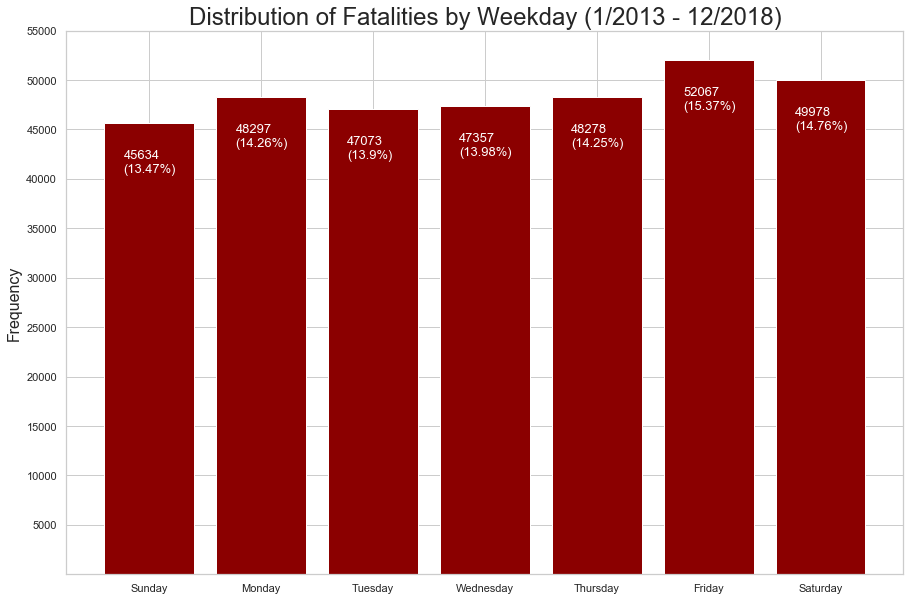

In [27]:
# Create plot, title, and axes labels
fig1D, ax1D = plt.subplots(figsize=(15,10))
ax1D.bar(death_by_weekday.index,
         death_by_weekday.fatality,
         color='#8b0000')

ax1D.set_title('Distribution of Fatalities by Weekday (1/2013 - 12/2018)',size=24)
ax1D.set_ylabel('Frequency',size=16)
ax1D.set_yticks([5000*i for i in range(1,12)])

# Create data labels
total = sum([i.get_height() for i in ax1D.patches])
for i in ax1D.patches:
    ax1D.text(i.get_x()+0.17,
              i.get_height()-5000,
              str(int(i.get_height()))+'\n('+str(round(i.get_height()/total*100,2))+'%)',
              fontsize=13,color='white')

#plt.savefig('../graphics/CP1-02_fig02D.png') # Export plot to PNG file
plt.show()

The plot shows that the greatest number of fatalities occur on a Friday (15.37%). However, this is only a marginal increase from fatalities that occur on Saturday (14.77%) or Monday (14.26%). [TOC](#TOC)

<a id='Sec02E'></a>
#### 2E: Fatalities by Time of Day (2013 - 2018)

At what time of the day does the highest frequency of fatalities occur?

In [28]:
# Subset all fatalities by time of day
death_by_hour = fatalities[['fatality']].groupby(fatalities.index.strftime('%H')).sum()

In [29]:
#death_by_hour

In [30]:
# Format index
hr = {x.strftime('%H'):x.strftime('%I %p') for x in fatalities.index}
od = OrderedDict(sorted(hr.items(),key=lambda t: t[0]))
death_by_hour.index = list(od.values())

In [31]:
death_by_hour

,fatality
12 AM,11623.0
01 AM,9440.0
02 AM,8230.0
03 AM,7276.0
04 AM,6951.0
05 AM,6523.0
06 AM,7300.0
07 AM,9639.0
08 AM,12631.0
09 AM,14291.0


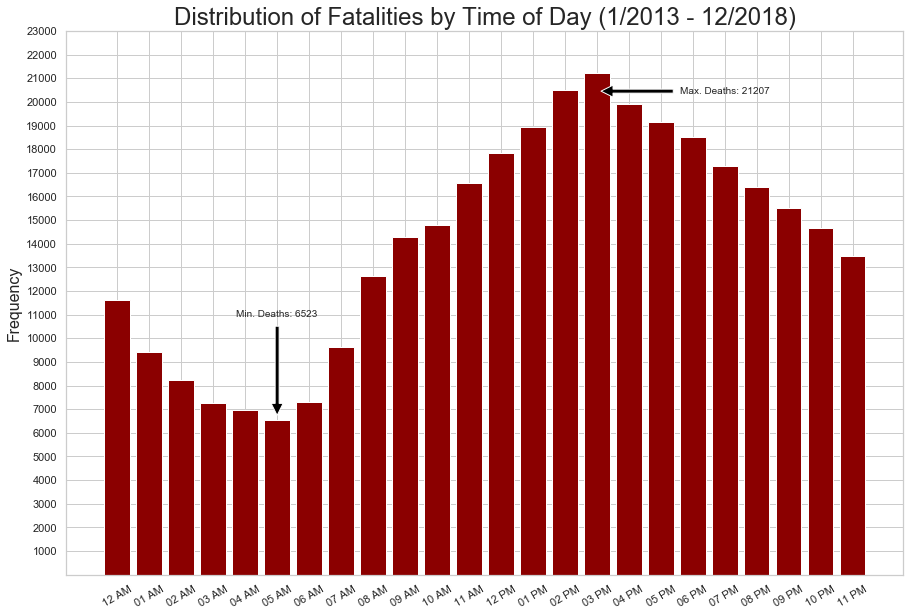

In [32]:
# Create plot, title, and axes labels
fig1E, ax1E = plt.subplots(figsize=(15,10))
ax1E.bar(death_by_hour.index,
         death_by_hour.fatality,
         color='#8b0000')

ax1E.set_title('Distribution of Fatalities by Time of Day (1/2013 - 12/2018)',size=24)
ax1E.set_xticklabels(death_by_hour.index,rotation=30)
ax1E.set_ylabel('Frequency',size=16)
ax1E.set_yticks([1000*i for i in range(1,24)])

#Include annotation for time of day with maximum fatality
ax1E.annotate('Max. Deaths: {}'.format(int(death_by_hour.fatality.max())),
              xy=(death_by_hour.fatality.idxmax(),death_by_hour.fatality.max()-750),
              xytext=('07 PM',death_by_hour.fatality.max()-750),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

#Include annotation for time of day with minimum fatality
ax1E.annotate('Min. Deaths: {}'.format(int(death_by_hour.fatality.min())),
              xy=(death_by_hour.fatality.idxmin(),death_by_hour.fatality.min()),
              xytext=('05 AM',death_by_hour.fatality.min()+4500),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

#plt.savefig('../graphics/CP1-02_fig02E.png') # Export plot to PNG file
plt.show()

According to the plot above, the highest number of fatalities across the six year period occur at 3:00 pm while the lowest amount of fatalities occur at 5:00 am on any given day. [TOC](#TOC)

*** 

## 3. FATALITIES BY GEOGRAPHIC REGION

<a id='Sec03A'></a>
#### 3A: Fatalities by Borough

What is the frequency of fatalities within each borough of the City of New York?

In [33]:
# Subset all fatalities by borough
deaths_by_borough = fatalities[['fatality']].groupby(fatalities.borough).sum().sort_values(by='fatality',ascending=False).head()

In [34]:
deaths_by_borough

,fatality
borough,
MANHATTAN,105376.0
BROOKLYN,91912.0
BRONX,72046.0
QUEENS,57956.0
STATEN ISLAND,11394.0


In [35]:
# Total Percentage of Fatalities by Borough (2013-2018)
df[(df.fatality==True) & (df.borough!='UNKNOWN')].borough.value_counts(normalize=True).head()

MANHATTAN        0.311134
BROOKLYN         0.271380
BRONX            0.212723
QUEENS           0.171121
STATEN ISLAND    0.033642
Name: borough, dtype: float64

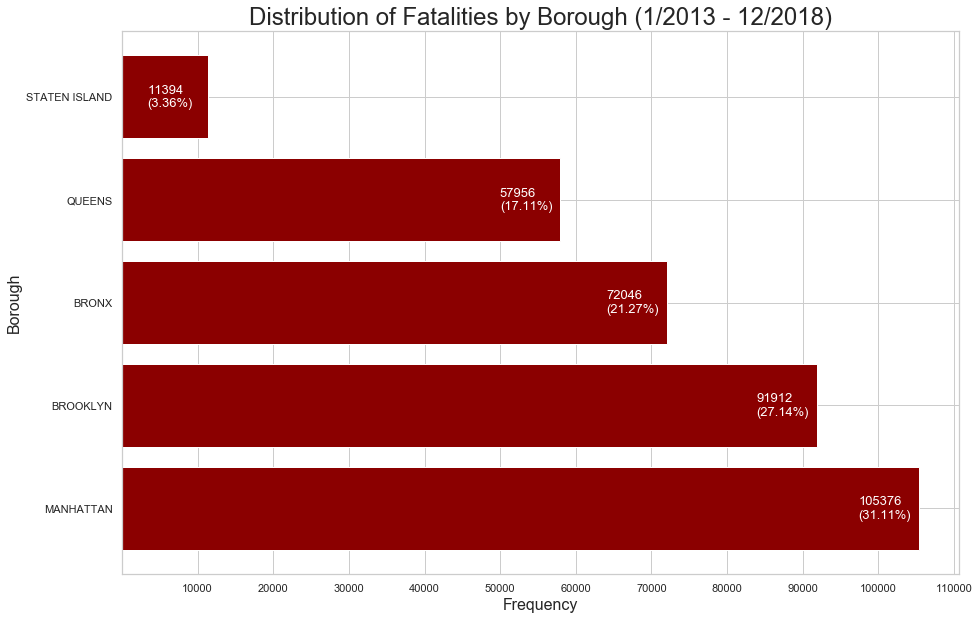

In [36]:
# Create plot, title, and axes labels
fig2A, ax2A = plt.subplots(figsize=(15,10))
ax2A.barh(deaths_by_borough.index,
         deaths_by_borough.fatality,
         color='#8b0000')

ax2A.set_title('Distribution of Fatalities by Borough (1/2013 - 12/2018)',size=24)
ax2A.set_xlabel('Frequency',size=16)
ax2A.set_xticks([10000*i for i in range(1,12)])
ax2A.set_ylabel('Borough',size=16)

# Create data labels
total = sum([i.get_width() for i in ax2A.patches])
for i in ax2A.patches:
    ax2A.text(i.get_width()-8000,
             i.get_y()+0.3,
             str(int(i.get_width()))+'\n('+str(round(i.get_width()/total*100,2))+'%)',
             fontsize=13,color='white')

#plt.savefig('../graphics/CP1-02_fig03A.png') # Export plot to PNG file
plt.show()

The bar chart shows that the highest portion of fatalities that result from EMS incidents (31.1%) occur in Manhattan. This an interesting observation given that the populations of Brooklyn and Queens, respectively, are each historically greater than the population of Manhattan. [TOC](#TOC)

*[Source](https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-total.html): U.S. Census Bureau, Population Division, 
        Annual Estimates of the Resident Population: April 1, 2010 to July 1, 2018*

<a id='Sec03B'></a>
#### 3B: Fatalities by ZIP Code

Which ZIP codes contain the highest concentration of fatalities over the six-year period?

In [37]:
# Subset all fatalities by ZIP code
deaths_by_zipcode = fatalities[['fatality']].groupby(fatalities.zipcode).sum().sort_values(by='fatality',ascending=False)

In [38]:
deaths_by_zipcode

,fatality
zipcode,
10001.0,5771.0
10456.0,5746.0
10003.0,5411.0
11207.0,5390.0
10035.0,5362.0
...,...
10167.0,1.0
10279.0,1.0
10177.0,0.0


In [39]:
# Define function to plot full shapefile 
def plot_map(sf, x_lim = None, y_lim = None, figsize = (20,20)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            #plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [60]:
"""
    INPUT CODE TO PLOT HEATMAP OF FATALITIES 
    BY ZIPCODE THROUGHOUT NYC 
 """

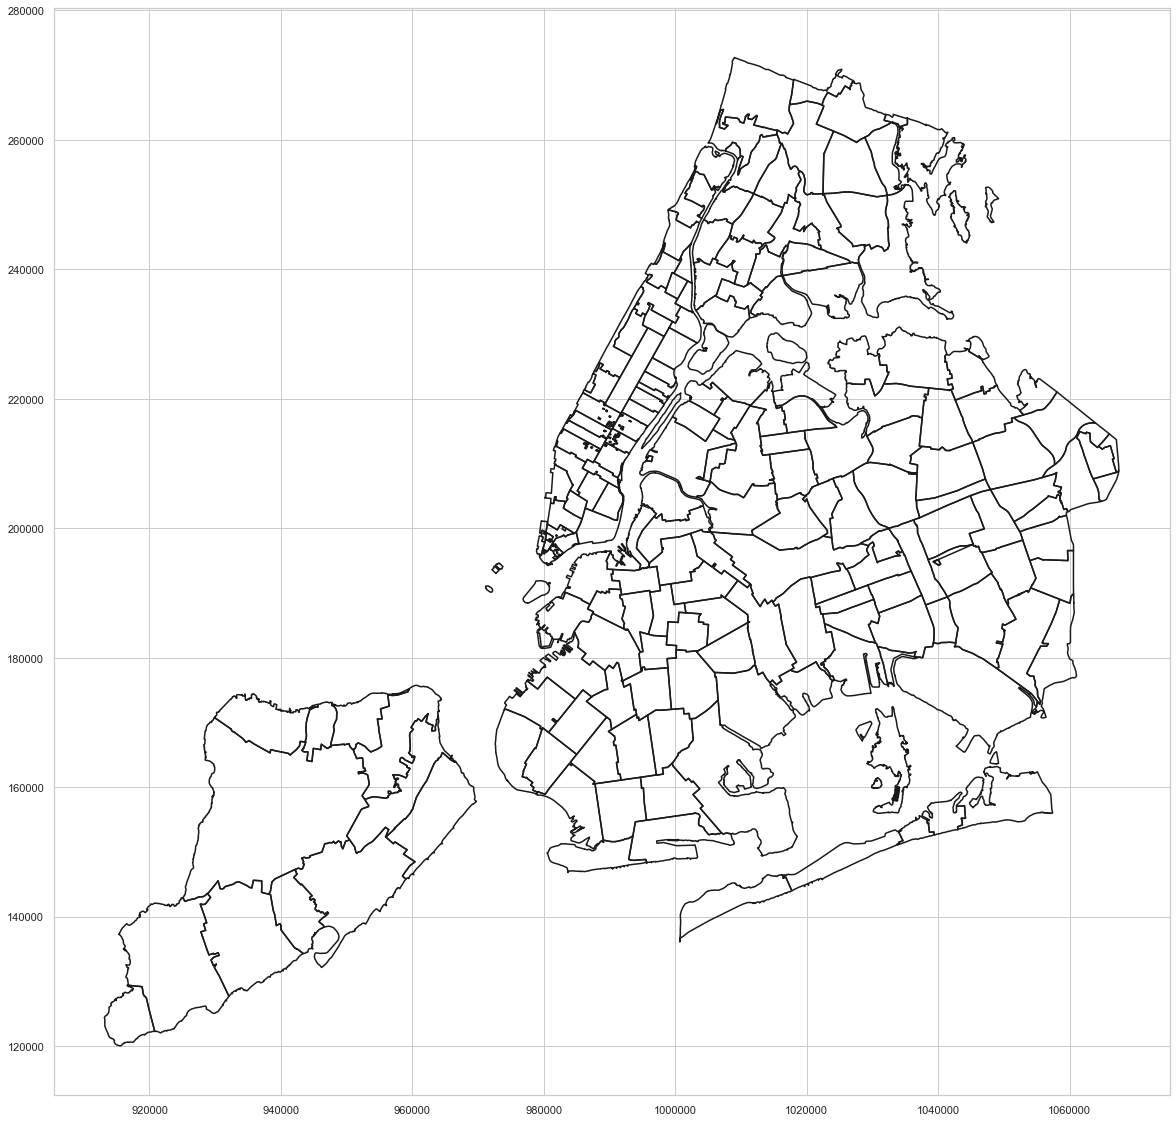

In [41]:
# Plot heatmap of fatalities by ZIP code
plot_map(sf)
#plt.savefig('../graphics/CP1-02_fig03B.png') # Export plot to PNG file

[TOC](#TOC)

***  

## 4. Incident Response Times

<a id='Sec04A'></a>
#### 4A: Total Response Times

How do the distributions of response times for 'fatalities' compare to those for 'survivals'?

In [39]:
response_times = df[['response_time','fatality']]
response_times.head()

,response_time,fatality
incident_datetime,,
2013-01-01 00:00:04,797.0,False
2013-01-01 00:05:52,534.0,False
2013-01-01 00:20:37,697.0,False
2013-01-01 01:53:11,223.0,False
2013-01-01 01:54:28,298.0,False


In [40]:
# Define function to avg. response time on boxplot
"""
    
"""
def lbl_avg_rspn_tm(dfObj,ax,fatality=True):
    # Include annotations for mean and median response times for fatalities
    ax.annotate('Median\n {:.2f}'.format(np.median(dfObj.loc[dfObj['fatality']==fatality].response_time)),
              xy=(np.median(dfObj.loc[dfObj['fatality']==fatality].response_time),0.9),
              xytext=(np.median(dfObj.loc[dfObj['fatality']==fatality].response_time),0.65),
              ha='center',
              arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Mean\n {:.2f}'.format(np.mean(dfObj.loc[dfObj['fatality']==True].response_time)),
              xy=(np.mean(dfObj.loc[dfObj['fatality']==fatality].response_time),0.9),
              xytext=(np.mean(dfObj.loc[dfObj['fatality']==fatality].response_time),0.65),
              ha='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

    # Include annotations for mean and median response times for survivals
    ax.annotate('Median\n{:.2f}'.format(np.median(dfObj.loc[dfObj.fatality==False].response_time)),
              xy=(np.median(dfObj.loc[dfObj['fatality']==False].response_time),1.9),
              xytext=(np.median(dfObj.loc[dfObj['fatality']==False].response_time),1.65),
              ha='center',
              arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Mean\n{:.2f}'.format(np.mean(dfObj.loc[dfObj['fatality']==False].response_time)),
              xy=(np.mean(dfObj.loc[dfObj['fatality']==False].response_time),1.9),
              xytext=(np.mean(dfObj.loc[dfObj['fatality']==False].response_time),1.65),
              ha='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

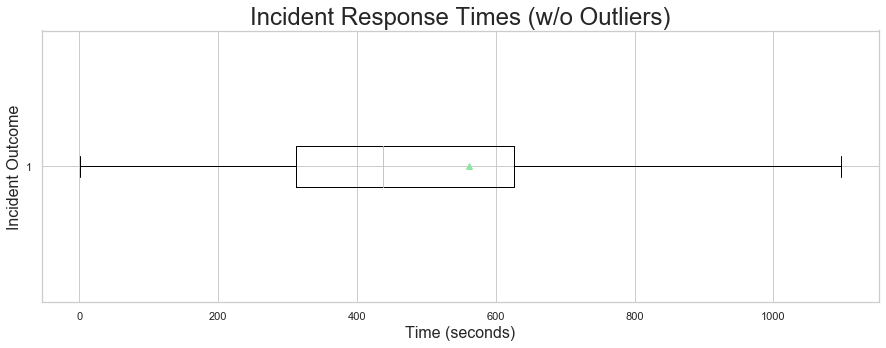

In [41]:
# Create plot, title, and axes labels
fig4A, ax4A = plt.subplots(figsize=(15,5))
ax4A.boxplot(response_times.response_time,
             sym='',vert=False,showmeans=True)

ax4A.set_title('Incident Response Times (w/o Outliers)',size=24)
ax4A.set_xlabel('Time (seconds)',size=16)
#ax4A.set_xticks([100*i for i in range(15)])
ax4A.set_ylabel('Incident Outcome',size=16)
#ax4A.set_yticks()

#annotate_rspn_tm(response_times,ax4A)

#plt.savefig('../graphics/CP1-02_fig04A.png') # Export plot to PNG file
plt.show()

[TOC](#TOC)

<a id='Sec04B'></a>
#### 4B: Response Times by Incident Outcome

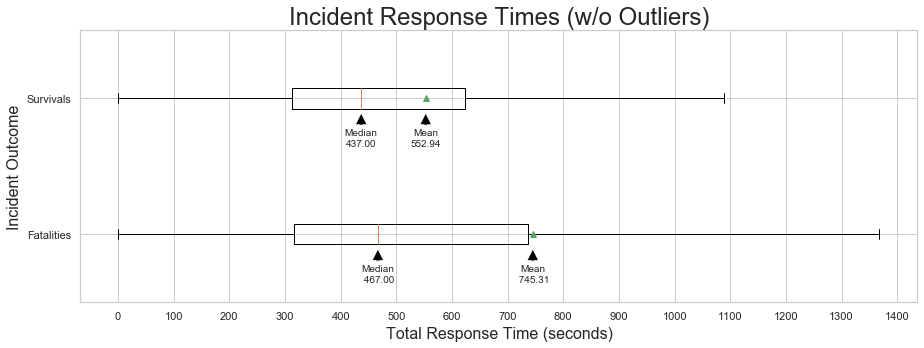

In [45]:
# Create plot, title, and axes labels
fig4B, ax4B = plt.subplots(figsize=(15,5))
ax4B.boxplot([response_times.loc[response_times['fatality']==True].total_response_time,
              response_times.loc[response_times['fatality']==False].total_response_time],
             sym='',vert=False,showmeans=True)

ax4B.set_title('Incident Response Times (w/o Outliers)',size=24)
ax4B.set_xlabel('Total Response Time (seconds)',size=16)
ax4B.set_xticks([100*i for i in range(15)])
ax4B.set_ylabel('Incident Outcome',size=16)
ax4B.set_yticklabels(['Fatalities','Survivals'])

annotate_rspn_tm(response_times,ax4B)

#plt.savefig('../graphics/CP1-02_fig04B.png') # Export plot to PNG file
plt.show()

The median response time for fatalities is 30 seconds higher than that for survivals. The mean response times for fatalities is more than three minutes higher than that for the survivals.

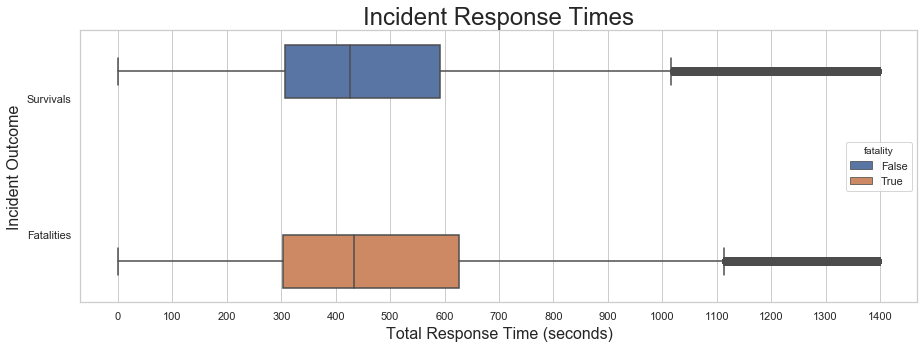

In [34]:
# Create plot, title, and axes labels
fig4B, ax4B = plt.subplots(figsize=(15,5))
ax4B = sns.boxplot(y='fatality',
                   x='total_response_time',
                   data=response_times[response_times.total_response_time<1400],
                   hue='fatality',
                   orient='h')

ax4B.set_title('Incident Response Times',size=24)
ax4B.set_xlabel('Total Response Time (seconds)',size=16)
ax4B.set_xticks([100*i for i in range(15)])
ax4B.set_ylabel('Incident Outcome',size=16)
ax4B.set_yticklabels(['Survivals','Fatalities'])

#plt.savefig('../graphics/CP1-02_rspn_tm1B.png') # Export plot to PNG file
plt.show()

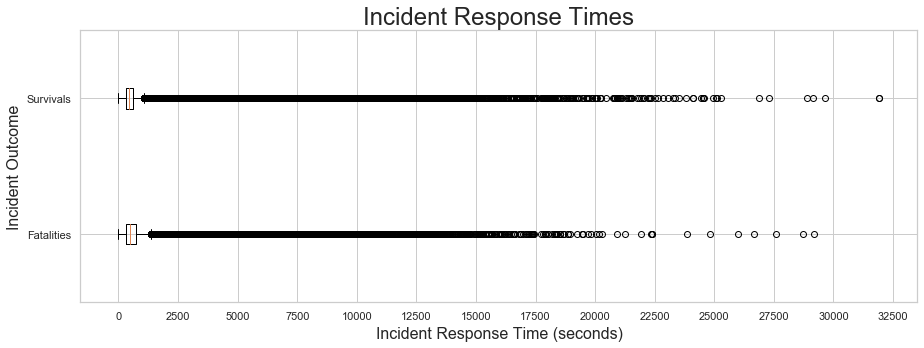

In [35]:
# Create plot, title, and axes labels
fig4C, ax4C = plt.subplots(figsize=(15,5))
ax4C.boxplot([response_times[response_times.fatality==True].total_response_time,
              response_times[response_times.fatality==False].total_response_time],
             vert=False)

ax4C.set_title('Incident Response Times (w/ Outliers)',size=24)
ax4C.set_xlabel('Incident Response Time (seconds)',size=16)
ax4C.set_xticks([2500*i for i in range(14)])
ax4C.set_ylabel('Incident Outcome',size=16)
ax4C.set_yticklabels(['Fatalities','Survivals'])

#plt.savefig('../graphics/CP1-02_rspn_tm2C.png') # Export plot to PNG file
plt.show()

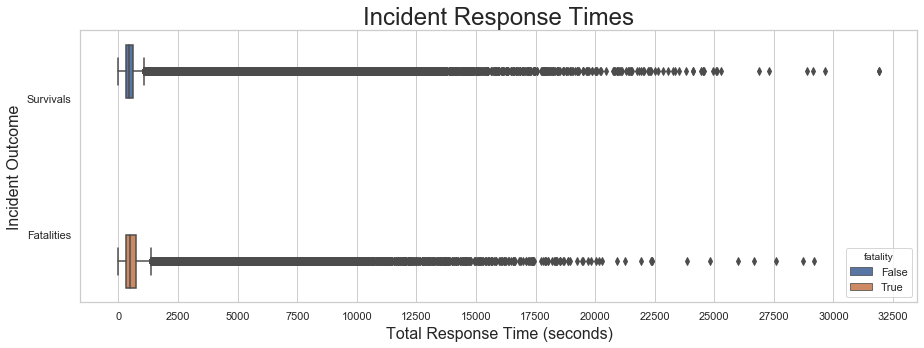

In [37]:
# Create plot, title, and axes labels
fig4C, ax4C = plt.subplots(figsize=(15,5))
ax4C = sns.boxplot(y='fatality',
                   x='total_response_time',
                   data=response_times,
                   hue='fatality',
                   orient='h')

ax4C.set_title('Incident Response Times (w/ Outliers)',size=24)
ax4C.set_xlabel('Total Response Time (seconds)',size=16)
ax4C.set_xticks([2500*i for i in range(14)])
ax4C.set_ylabel('Incident Outcome',size=16)
ax4C.set_yticklabels(['Survivals','Fatalities'])

#plt.savefig('../graphics/CP1-02_rspn_tm2C.png') # Export plot to PNG file
plt.show()

[TOC](#TOC) 

<a id='Sec04C'></a>
#### 4C: Response Time by Final Severity Level

In [46]:
# Subset all fatalities by final severity level and total response time
response_vs_severity = df[['final_severity_level','total_response_time','fatality']]
response_vs_severity.head()

,final_severity_level,total_response_time,fatality
incident_datetime,,,
2013-01-01 00:00:04,4,797.0,False
2013-01-01 00:00:19,3,851.0,False
2013-01-01 00:01:04,1,429.0,True
2013-01-01 00:01:16,6,828.0,False
2013-01-01 00:01:26,5,856.0,False


In [47]:
# Create 'rspn_time_arr' subsets for each severity level code
rspn_time_sev_arr = [response_vs_severity[response_vs_severity.final_severity_level==i] for i in range(1,9)]

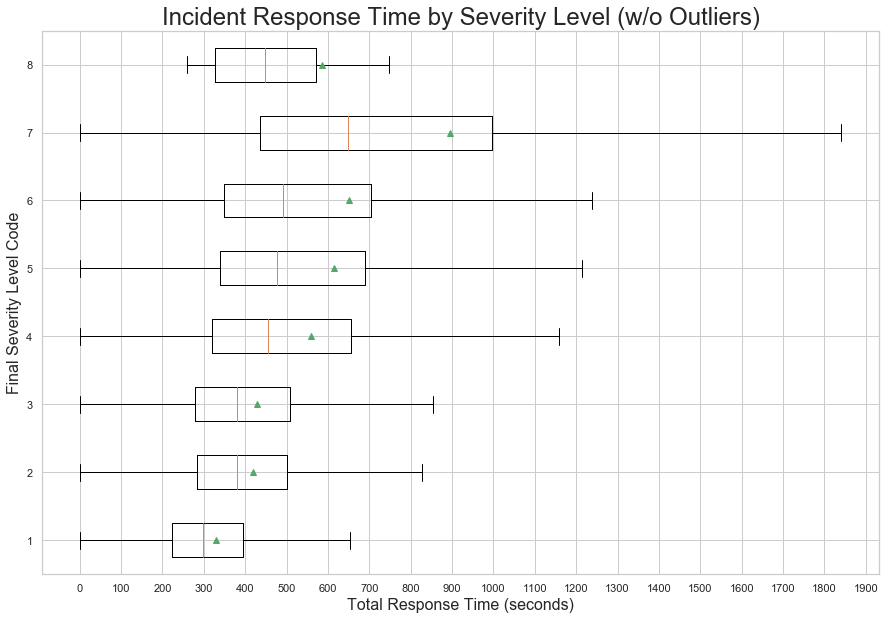

In [53]:
# Create boxplot
fig6A, ax6A = plt.subplots(figsize=(15,10))
ax6A.boxplot([rspn_time_sev_arr[k].total_response_time for k in range(8)],
             sym='',
             vert=False,
             showmeans=True)
ax6A.set_title('Incident Response Time by Severity Level (w/o Outliers)',size=24)
ax6A.set_ylabel('Final Severity Level Code',size=16)
ax6A.set_xlabel('Total Response Time (seconds)',size=16)
ax6A.set_xticks([100*i for i in range(20)])

#plt.savefig('../graphics/CP1-02_sev_vs_rspn_tm1A.png') # Export plot to PNG file
plt.show()

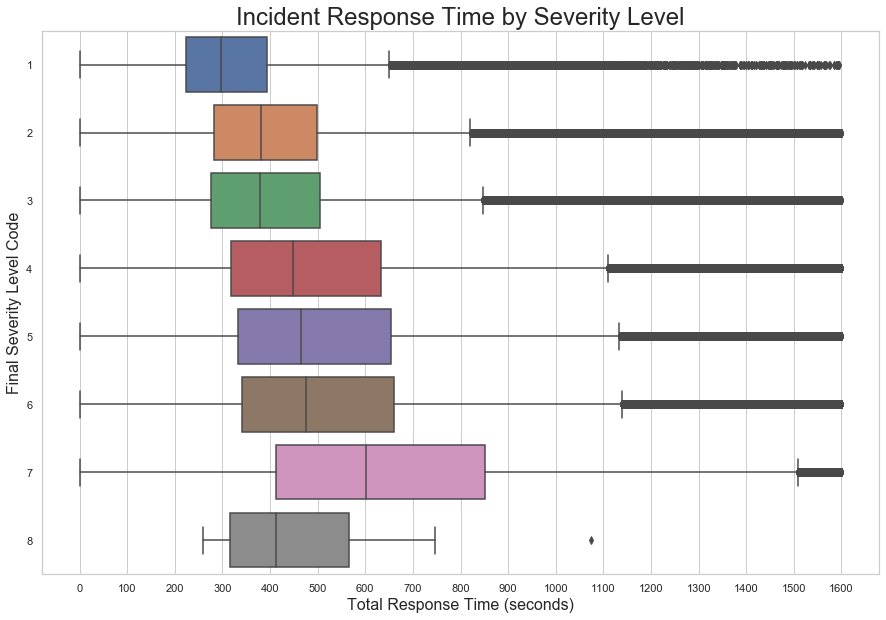

In [49]:
# Create boxplot
fig6A, ax6A = plt.subplots(figsize=(15,10))
ax6A = sns.boxplot(y='final_severity_level',
                   x='total_response_time',
                   data=response_vs_severity[response_vs_severity.total_response_time<1600],
                   orient='h')
ax6A.set_title('Incident Response Time by Severity Level',size=24)
ax6A.set_ylabel('Final Severity Level Code',size=16)
ax6A.set_xlabel('Total Response Time (seconds)',size=16)
ax6A.set_xticks([100*i for i in range(17)])

#plt.savefig('../graphics/CP1-02_sev_vs_rspn_tm1B.png') # Export plot to PNG file
plt.show()

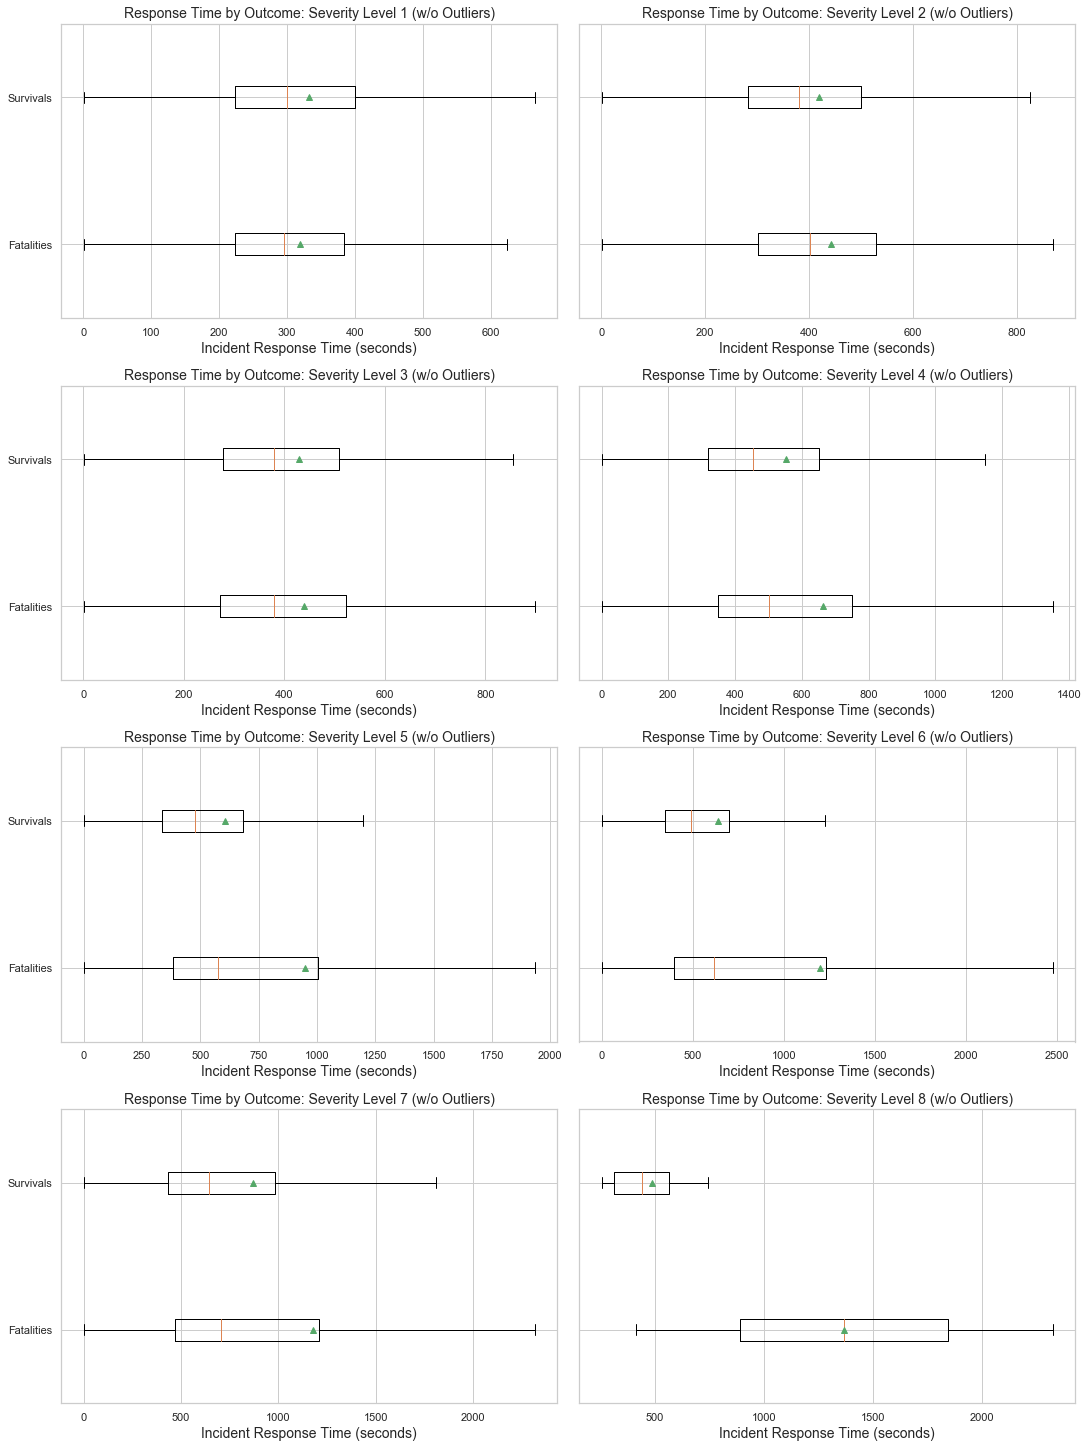

In [51]:
# Initialize plot and axes
nrows = int(math.ceil(len(rspn_time_sev_arr)/2)) # equal to half the length of 'rspn_time_sev_arr'
ncols = 2
fig6B, ax6B = plt.subplots(nrows,ncols,figsize=(15,20),sharey=True,constrained_layout=True)

# Plot each 'response_vs_severity' subset on its own axis
for k, ax in enumerate(ax6B.flat):
    ax.boxplot([rspn_time_sev_arr[k].loc[rspn_time_sev_arr[k]['fatality']==True].total_response_time,
                rspn_time_sev_arr[k].loc[rspn_time_sev_arr[k]['fatality']==False].total_response_time],
               sym='',
               vert=False,
               showmeans=True)
    ax.set_title('Response Time by Outcome: Severity Level {} (w/o Outliers)'.format(k+1),size=14)
    ax.set_xlabel('Time (seconds)',size=14)
    ax.set_yticklabels(['Fatalities','Survivals'])
    
    #annotate_rspn_tm(rspn_time_sev_arr[k],ax)
    
#plt.savefig('../graphics/CP1-02_sev_vs_rspn_tm2A.png') # Export plot to PNG file
plt.show()

In [ ]:
# Initialize plot and axes
nrows = int(math.ceil(len(rspn_time_sev_arr)/2)) # equal to half the length of 'rspn_time_sev_arr'
ncols = 2
fig6C, ax6C = plt.subplots(nrows,ncols,figsize=(15,20),sharey=True,constrained_layout=True)

# Plot each 'response_vs_severity' subset on its own axis
for k, ax in enumerate(ax6C.flat):
    ax.violinplot(x=,
                  y=rspn_time_sev_arr[k].total_response_time,
                rspn_time_sev_arr[k].loc[rspn_time_sev_arr[k]['fatality']==False].total_response_time],
               sym='',
               vert=False,
               showmeans=True)
    ax.set_title('Response Time by Outcome: Severity Level {} (w/o Outliers)'.format(k+1),size=14)
    ax.set_xlabel('Time (seconds)',size=14)
    ax.set_yticklabels(['Fatalities','Survivals'])
    
    #annotate_rspn_tm(rspn_time_sev_arr[k],ax)
    
#plt.savefig('../graphics/CP1-02_sev_vs_rspn_tm2A.png') # Export plot to PNG file
plt.show()

[TOC](#TOC)

***

## 5. Incident Call Types & Severity Levels

<a id='Sec05A'></a>
#### 5A: Fatalities by Call Type

Which category of call types for EMS incidents result in the greatest number of fatalities?

In [42]:
# Subset all fatalities by final call type
deaths_by_call_type = fatalities[['fatality']].groupby(fatalities.final_call_type).sum().sort_values(by='fatality',ascending=False)
deaths_by_call_type

,fatality
final_call_type,
EDP,54510.0
ARREST,52691.0
DRUG,44243.0
INJURY,41436.0
UNC,31529.0
...,...
MCI35P,1.0
MCI32,1.0
MCI22P,1.0


In [43]:
# Top five call types that result in fatality
fatal_five = deaths_by_call_type.head()
fatal_five

,fatality
final_call_type,
EDP,54510.0
ARREST,52691.0
DRUG,44243.0
INJURY,41436.0
UNC,31529.0


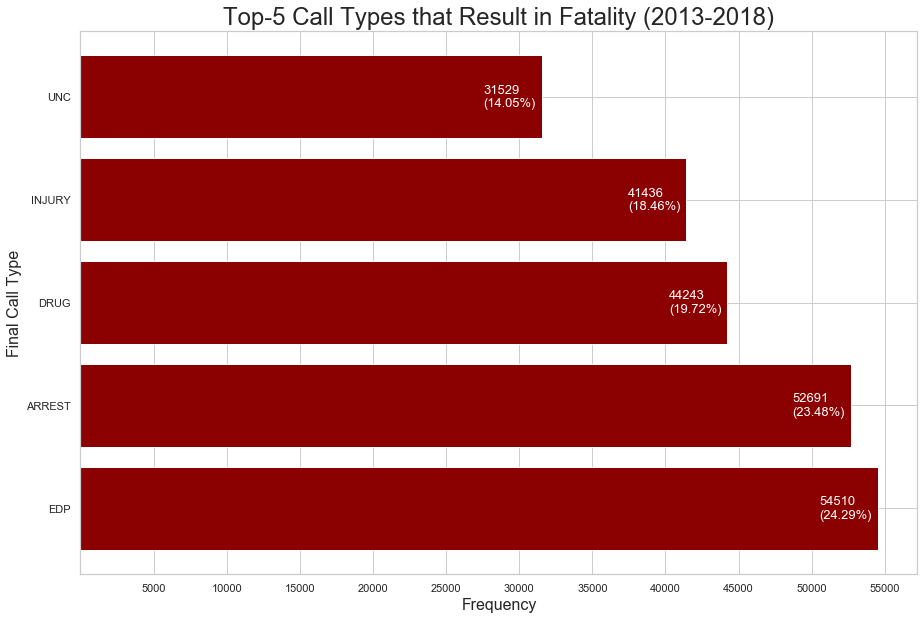

In [44]:
# Create plot, title, and axes labels
fig3, ax3 = plt.subplots(figsize=(15,10))
ax3.barh(fatal_five.index,
         fatal_five.fatality,
         color='#8b0000')

ax3.set_title('Top-5 Call Types that Result in Fatality (2013-2018)',size=24)
ax3.set_xlabel('Frequency',size=16)
ax3.set_xticks([5000*i for i in range(1,12)])
ax3.set_ylabel('Final Call Type',size=16)

# Create data labels
total = sum([i.get_width() for i in ax3.patches])
for i in ax3.patches:
    ax3.text(i.get_width()-4000,
             i.get_y()+0.3,
             str(int(i.get_width()))+'\n('+str(round(i.get_width()/total*100,2))+'%)',
             fontsize=13,color='white')

#plt.savefig('../graphics/CP1-02_fig04A.png') # Export plot to PNG file
plt.show()

There are 135 different EMS incident call types that exist. The five call types that resulted in the greatest number of fatalities are:

+ EDP = Psychiatric Patient
+ ARREST = Cardiac Arrest
+ DRUG = HX Drug or Alcohol Abuse
+ INJURY = Non-Critical Injury
+ UNC = Unconscious Patient

[TOC](#TOC)

<a id='Sec05B'></a>
#### 5B: Incident Outcomes by Severity Levels

To what extent does the incident assessment determined from caller-provided information (`initial_severity_level`) correlate with the assessment made by response personnel on-the-scene (`final_severity_level`)?

In [45]:
# Subset all fatalities by initial and final severity level code
severity_levels = df[['initial_severity_level','final_severity_level','fatality']]
severity_levels.head()

,initial_severity_level,final_severity_level,fatality
incident_datetime,,,
2013-01-01 00:00:04,4,4,False
2013-01-01 00:05:52,7,7,False
2013-01-01 00:20:37,6,6,False
2013-01-01 01:53:11,4,4,False
2013-01-01 01:54:28,4,4,False


In [39]:
# # Create plot, title, and axes labels
# fig5, ax5 = plt.subplots(figsize=(15,5))
# ax5.scatter(x='initial_severity_level',
#                   y='final_severity_level',
#                   data=severity_levels)
# ax5.set_title('Initial Severity Level vs. Final Severity Level',size=16)
# ax5.set_xlabel('Initial Severity Level Code',size=16)
# #ax5.set_xticks([i for i in range(1,8)])
# ax5.set_ylabel('Final Severity Level Code',size=16)
# #ax5.set_yticks([i for i in range(1,8)])

# #plt.savefig('../graphics/CP1-02_severity_level.png') # Export plot to PNG file
# plt.show()

In [46]:
# Determine correlation between 'initial_severity_level' and 'final_severity_level'
x=np.array(severity_levels['initial_severity_level'])
y=np.array(severity_levels['final_severity_level'])

np.corrcoef(x,y)

array([[1.        , 0.93524575],
       [0.93524575, 1.        ]])

There is a strong, linear correlation between the initial_severity_level and the final_severity_level. This indicates that the determination for the severity of an incident made by dispatch--based on the information obtained by a caller--aligns closely to the determination made by on-scene EMS crew.

For this reason, the initial_severity_level will be omitted from any analyses used to develop ML algorithms given that it is a redundant predictor variable. [TOC](#TOC)

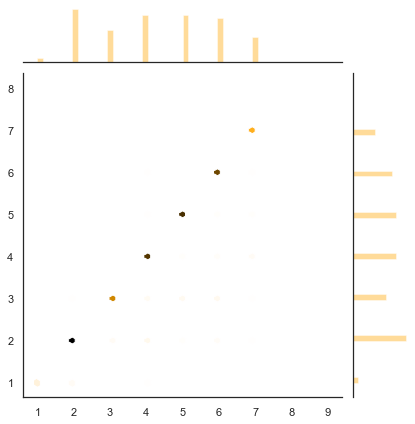

In [55]:
with sns.axes_style('white'):
    sns.jointplot(x=x, y=y, kind='hex', color='#FFA500')

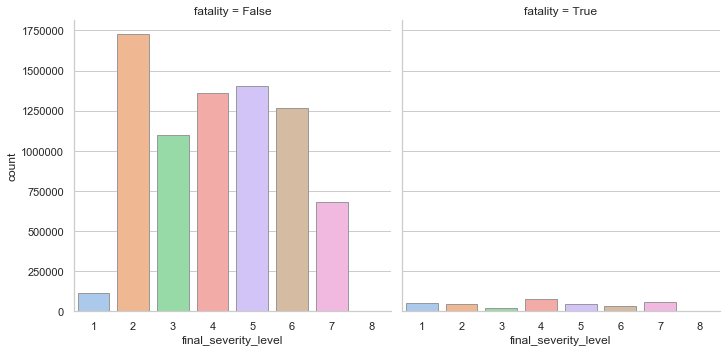

In [49]:
sns.catplot(x="final_severity_level", col="fatality", kind="count",
            palette="pastel", edgecolor=".6",
            data=severity_levels)

In [61]:
# ax5B = sns.FacetGrid(severity_levels,col='fatality')
# ax5B.map(plt.hist,'final_severity_level')
# # ax5B1 = sns.catplot(x="final_severity_level", kind="count",
# #             palette="pastel", edgecolor=".6",
# #             data=severity_levels[severity_levels.fatality==True])
# # ax5B2 = sns.catplot(x="final_severity_level", kind="count",
# #             palette="pastel", edgecolor=".6",
# #             data=severity_levels[severity_levels.fatality==False])



[TOC](#TOC)